# A Machine Learning Study of US House Prices
### - Sanskar Shrivastava


##### <span style="color: blue;">**The housing market in the United States has long been a subject of interest and concern for various stakeholders, including homeowners, real estate professionals, economists, and policymakers**</span>

##### <span style="color: blue;">**This case study aims to explore the multifaceted landscape of factors that affect housing prices in the United States. By delving into a comprehensive analysis of these factors, we can gain valuable insights into the dynamics of the housing market, helping both individuals and organizations make more informed decisions.**</span>


### Data Collection

##### Below are the factors that i chose for creation of the Model

1. **GDP Index**
   - Source: [S&P Global](https://www.spglobal.com/marketintelligence/en/mi/products/us-monthly-gdp-index.html)
   - Description: The GDP Index is used as a proxy for the economic health of the United States, which can impact housing prices.

2. **Income**
   - Source: [St. Louis Fed](https://fred.stlouisfed.org/series/PI)
   - Description: Total income earned by all individuals in the United States, indicating the overall financial capacity of potential homebuyers.

3. **Monthly Supply of New Houses**
   - Source: [St. Louis Fed](https://fred.stlouisfed.org/series/MSACSR)
   - Description: Represents the ratio of houses sold to the total number of houses available for sale each month, indicating the demand and supply dynamics of the housing market.

4. **Unemployment**
   - Source: [St. Louis Fed](https://fred.stlouisfed.org/series/UNRATE)
   - Description: The unemployment rate, indicating the percentage of the labor force without jobs, can impact housing demand and affordability.

5. **Population**
   - Source: [St. Louis Fed](https://fred.stlouisfed.org/series/POPTHM)
   - Description: Monthly estimates of the total population in the United States, influencing the demand for housing.

6. **New Privately-Owned Housing Units Under Construction**
   - Source: [St. Louis Fed](https://fred.stlouisfed.org/series/UNDCONTSA)
   - Description: Data on the number of new housing units authorized and under construction, reflecting the pace of new housing supply.

7. **Mortgage Rates**
   - Source: [Freddie Mac](https://www.freddiemac.com/pmms)
   - Description: The average 30-Year Fixed Rate Mortgage in the United States, affecting the affordability and financing options for potential homebuyers.



## Results


<font color="#006400"><h2>Most Important Factors:</h2></font>

| Variable                                     | Normalized Correlation | Pearson Correlation | Explanation                                        |
|----------------------------------------------|-------------------------|---------------------|----------------------------------------------------|
| Income                                       | 0.8                     | 0.75                | Strong positive correlation with housing prices.   |
| GDP Index                                    | 0.8                    | 0.75                | Strong positive correlation with housing prices.   |
| New Privately-Owned Housing Units Under Construction | 0.6            | 0.64                | Moderate positive correlation with housing prices. |
| Population                                   | 0.6                    | 0.63                | Moderate positive correlation with housing prices. |


<font color="#006400"><h2>Less Important Factors:</h2></font>

| Variable        | Normalized Correlation | Pearson Correlation | Explanation                                        |
|-----------------|-------------------------|---------------------|----------------------------------------------------|
| Unemployment    | -0.5                    | 0.51                | Moderate negative correlation with housing prices. |
| Mortgage        | -0.3                    | 0.3                 | Weak negative correlation with housing prices.     |
| ForSale_Sold    | -0.1                    | 0.084                | Very weak negative correlation with housing prices.|

<font color="#006400"><h2>Top Performing Models:</h2></font>

| Model Name                | Train RMSE | Test RMSE | Test Std | Time     |
|---------------------------|------------|-----------|----------|----------|
| Elasticnet                | 0.028412   | 0.046087  | 0.029836 | 0.111171 |
| Lasso                     | 0.028398   | 0.046754  | 0.030323 | 0.028566 |
| GradientBoostingRegressor | 0.005390   | 0.048369  | 0.055786 | 5.621939 |
| XGBRegressor              | 0.000692   | 0.050595  | 0.055145 | 0.869652 |


### Code and Description:

In [60]:
# Importing the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator


from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, TweedieRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

%matplotlib inline

In [40]:
# Reading the Data

data = pd.read_csv('HousePriceFactors(Monthly).csv')

In [41]:
#Printing the data to take a look

data.head()

,DATE,CSIndex,GDPIndex,Income,ForSale_Sold,Unemp,Population,UnitUnderCons,Mortgage
0,01-01-2003,128.460,11136.068,9297.2,4.0,5.8,289412,1049,5.9160
1,01-02-2003,129.355,11210.759,9302.0,4.5,5.9,289606,1044,5.8425
2,01-03-2003,130.147,11175.559,9341.7,4.1,5.9,289809,1044,5.7450
3,01-04-2003,130.884,11257.068,9369.8,4.1,6.0,290024,1043,5.8125
4,01-05-2003,131.734,11275.411,9431.9,3.9,6.1,290250,1047,5.4840


In [42]:
# Getting further description of Data

data.describe()

,CSIndex,GDPIndex,Income,ForSale_Sold,Unemp,Population,UnitUnderCons,Mortgage
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,181.140838,17222.490373,14783.228631,6.146058,6.001245,314899.796680,1006.207469,4.689902
std,41.844957,3761.848016,3611.655270,1.952241,2.036837,13748.604179,340.211439,1.113069
min,128.460000,11136.068000,9297.200000,3.300000,3.400000,289412.000000,414.000000,2.684000
25%,148.134000,14442.246000,12050.300000,4.800000,4.500000,303280.000000,726.000000,3.802500
50%,172.859000,16577.445000,14089.600000,5.600000,5.400000,316038.000000,1075.000000,4.457500
75%,198.294000,19919.933000,17294.800000,7.200000,7.300000,327969.000000,1222.000000,5.754000
max,304.817000,26485.233000,24371.900000,12.200000,14.700000,334533.000000,1710.000000,6.900000


In [43]:
# Dropping the Target Column and Preparing Training Features

data.drop(['DATE'], axis = 1, inplace = True)
train_data = data[:220]
test_data = data[220:]

y = train_data['CSIndex'].reset_index(drop=True)
train_features = train_data.drop(['CSIndex'], axis = 1)
test_features = test_data

### 1.Exploratory Data Analysis

### 1.1 Plotting the Co-relation Matrix

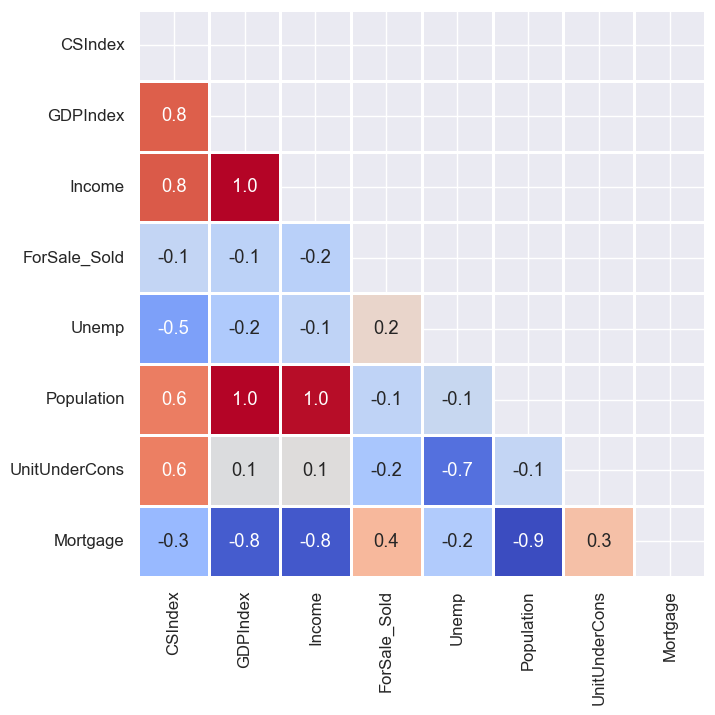

In [76]:
# Co-relation Matrix

sns.set(font_scale=1.1)
correlation_train = train_data.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

plt.show()

### 1.2 Plotting Case Shillar Index against Other Variables

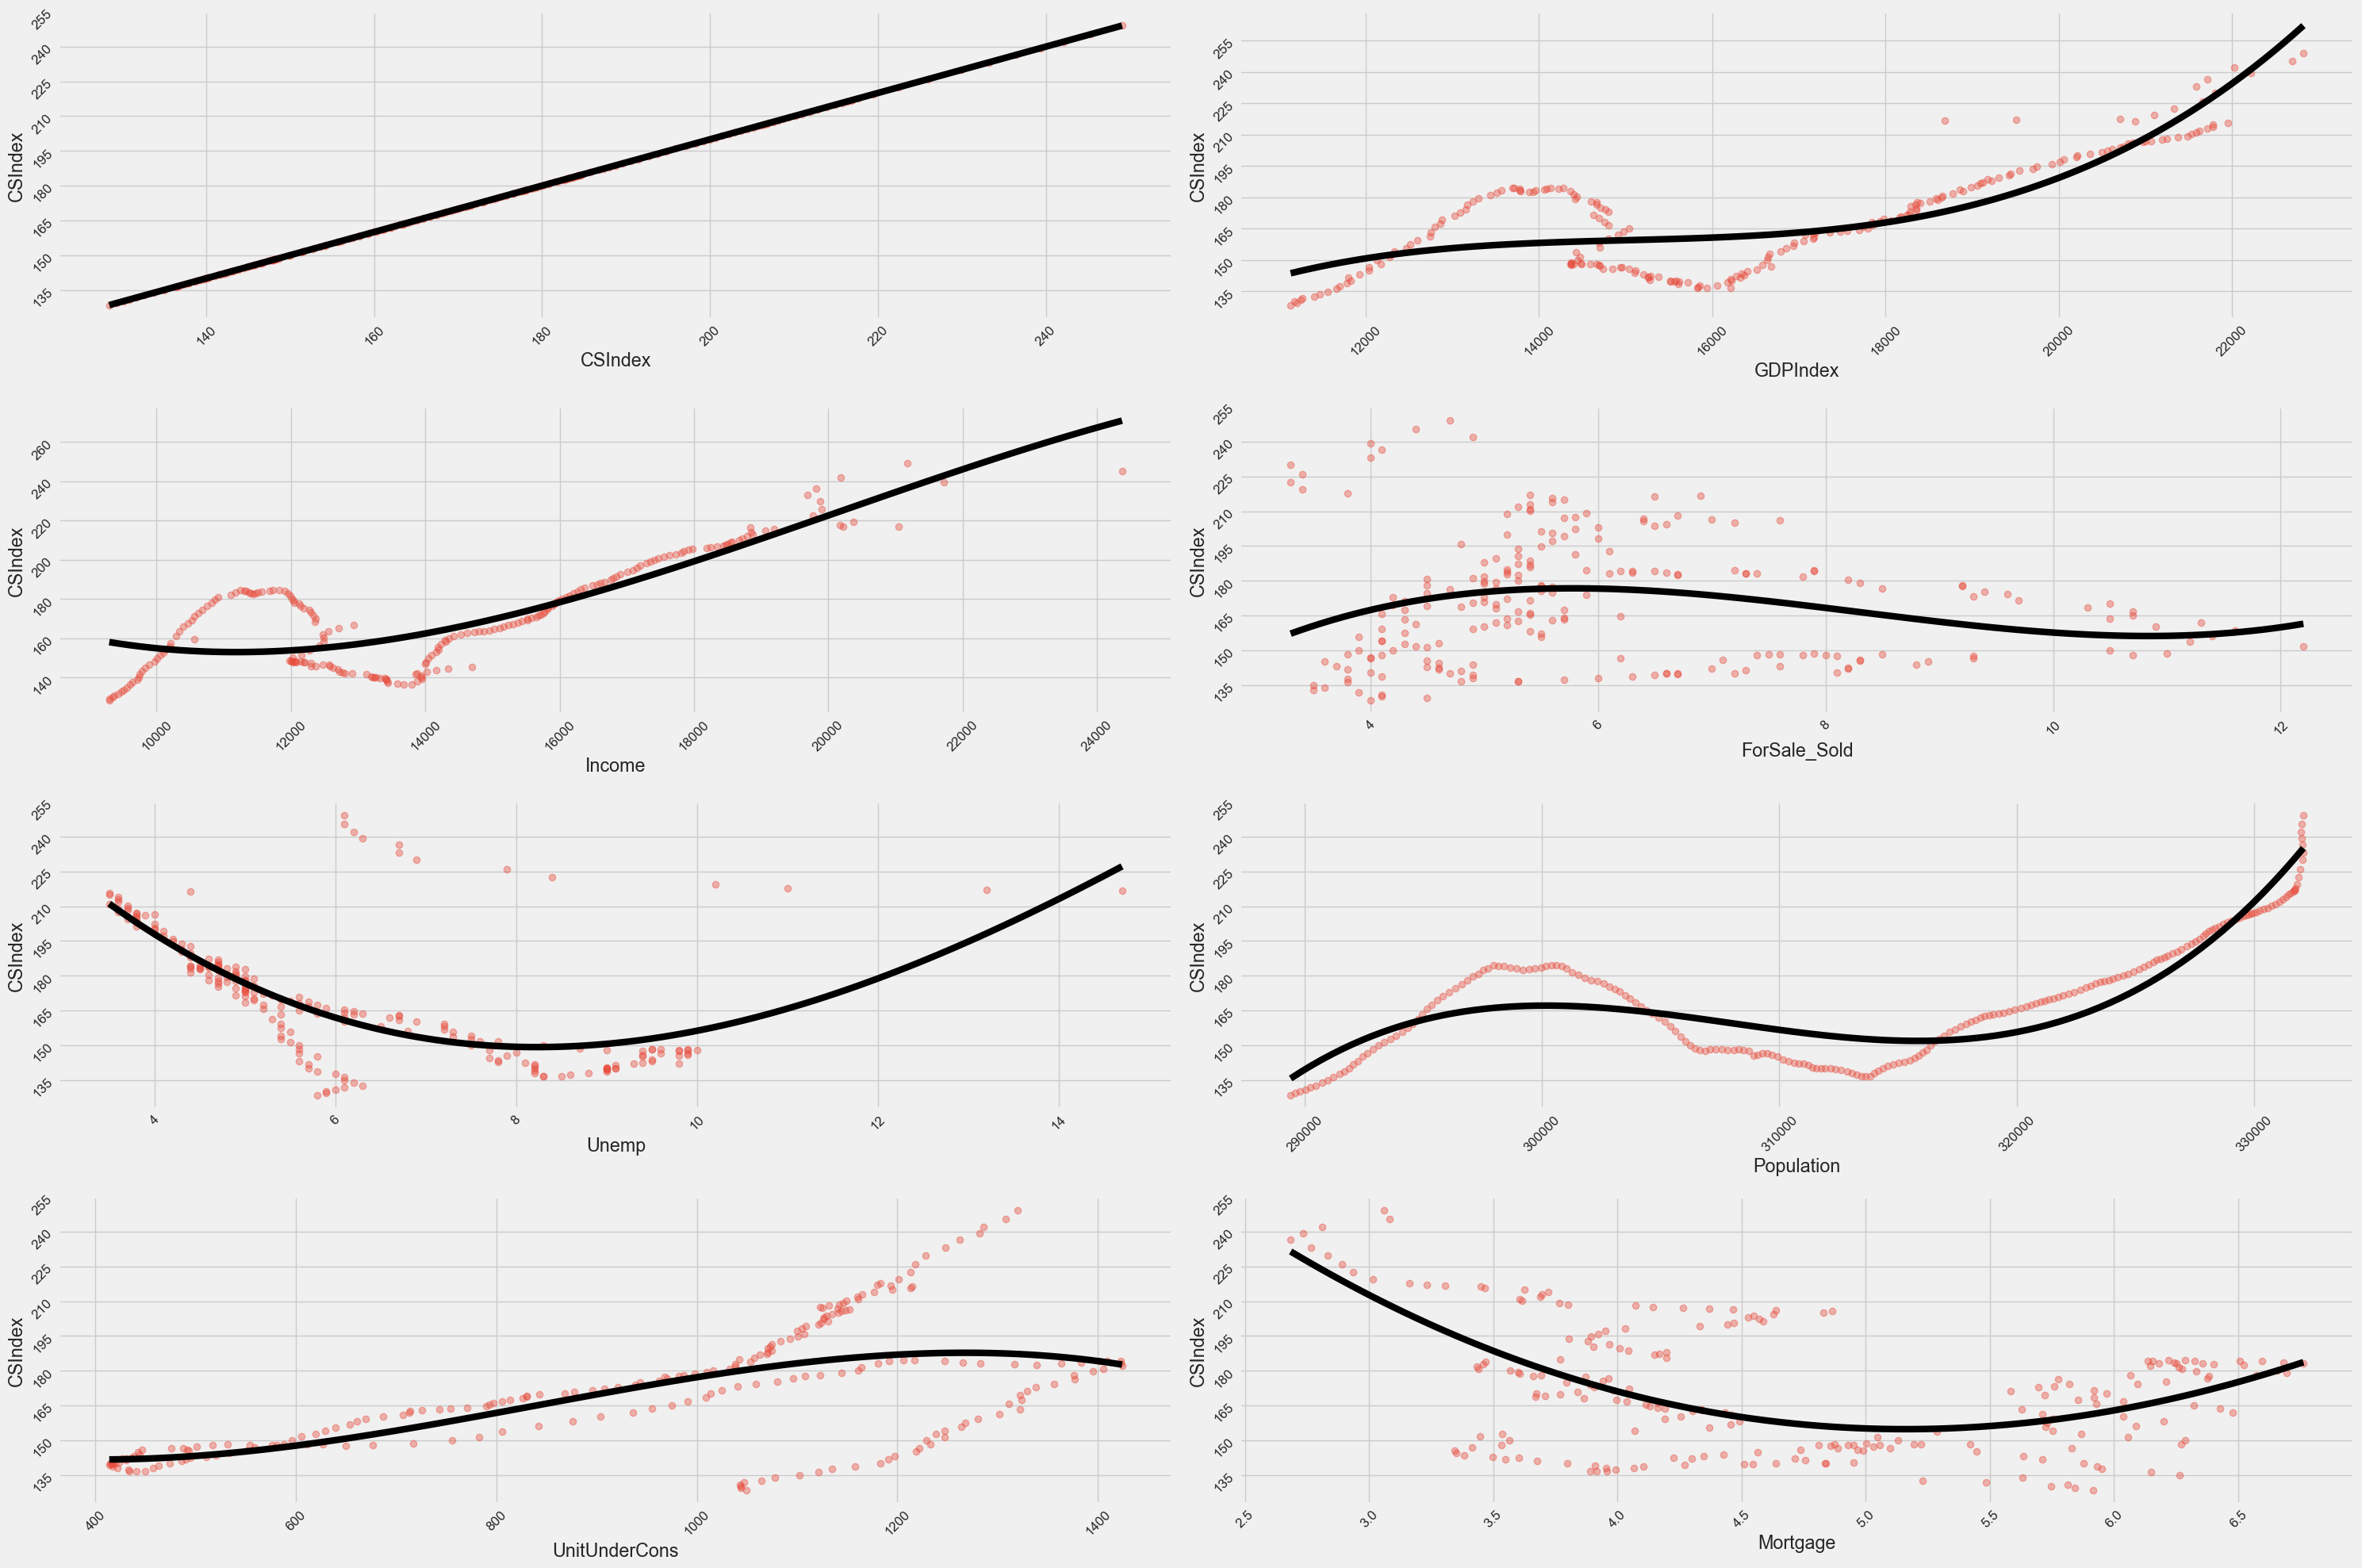

In [33]:
# Defining a fucntion to plot using seaborn

def srt_reg(y, df):
    fig, axes = plt.subplots(4, 2, figsize=(30, 20))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['number']).columns, axes):

        sns.regplot(x=i,
                    y=y,
                    data=df,
                    ax=j,
                    order=3,
                    ci=None,
                    color='#e74c3c',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()
        
srt_reg('CSIndex', train_data)

### 1.3 Plotting Peason Co-relation to get most important factors

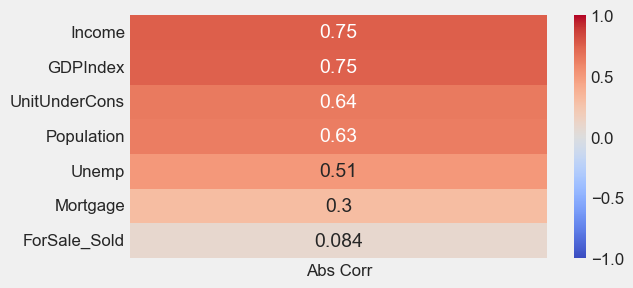

In [75]:
# Plotting Pearson Corelation at last to get idea of the Variables

correlations = train_features.join(y).corrwith(train_features.join(y)['CSIndex']).iloc[:-1].to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(6,3))
sns.heatmap(sorted_correlations.to_frame()[sorted_correlations>=0], cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);

## Results

After conducting our analysis, we found that the most important factors influencing housing prices in the United States, in decreasing order of importance, are:

### 1. <font color="#006400">Income</font>

### 2. <font color="#008000">GDP Index</font>

### 3. <font color="#00A000">New Privately-Owned Housing Units Under Construction</font>

### 4. <font color="#00C000">Population</font>


### 2.Applying some transformations on Data

In [56]:
def plot_prob_dist(df, feature, title):

    fig = plt.figure(constrained_layout=True, figsize=(10, 6))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
                     
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    
    
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 fit=norm,
                 ax=ax1,
                 color='#e74c3c')
    ax1.legend(labels=['Normal', 'Actual'])
    
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('Probability Plot')
    
    stats.probplot(df.loc[:, feature].fillna(np.mean(df.loc[:, feature])),plot=ax2)
                          
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(6.0)

    
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    
    sns.boxplot(df.loc[:, feature], orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.suptitle(f'{title}', fontsize=12)

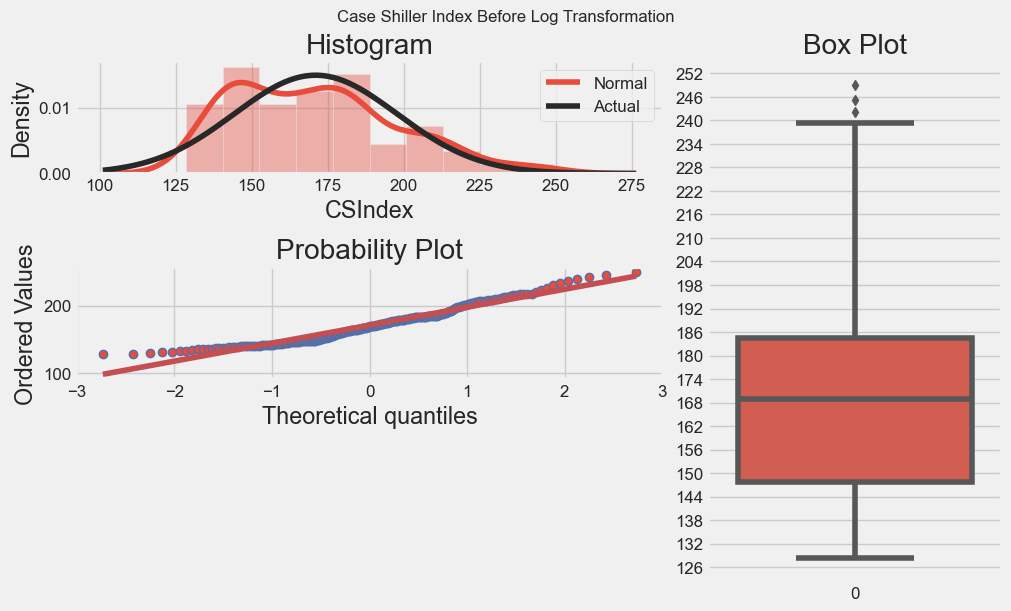

In [57]:
plot_prob_dist(train_features.join(y), 'CSIndex', 'Case Shiller Index Before Log Transformation')

In [58]:
# Applying Log Transformation

X = train_features
X_test = test_features
y = np.log1p(y)

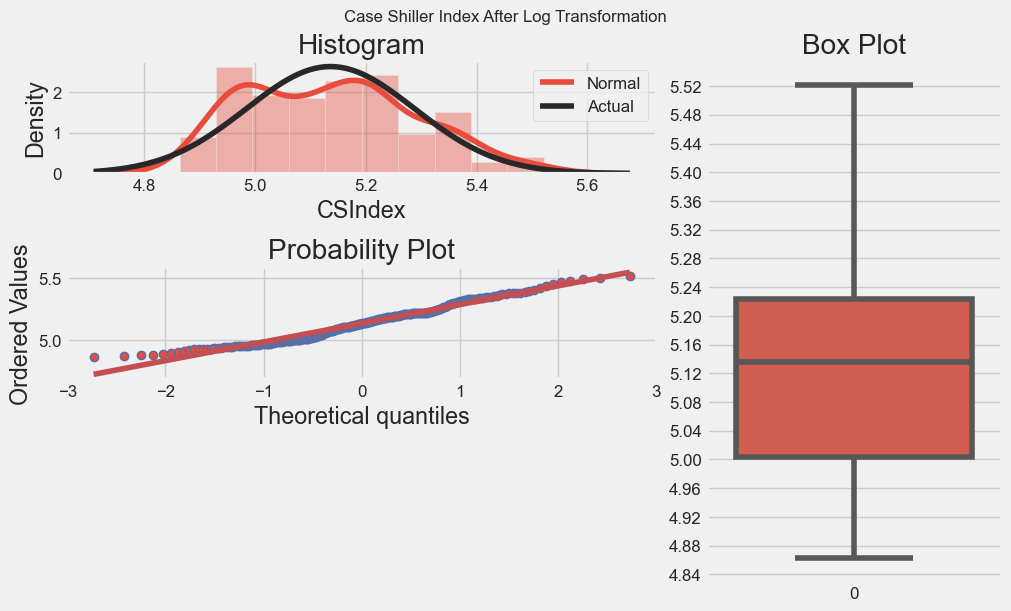

In [59]:
plot_prob_dist(train_features.join(y), 'CSIndex', 'Case Shiller Index After Log Transformation')

### 3.Creating a Regression Model

##### Here are the Models that we will Use for our application

1. **Ridge Regression**: Ridge regression is a linear regression variant that adds a penalty term to the ordinary least squares method to prevent overfitting by reducing the magnitude of the coefficients.

2. **Lasso Regression**: Lasso regression is another linear regression variant that adds a penalty term to the ordinary least squares method but can also perform feature selection by driving some coefficients to zero.

3. **ElasticNet Regression**: ElasticNet combines aspects of both Ridge and Lasso regression by using a linear combination of their penalties, offering a balance between regularization and feature selection.

4. **Support Vector Regression (SVR)**: SVR is a regression technique that uses support vector machines to find a hyperplane that best fits the data while minimizing the margin of error.

5. **Gradient Boosting Regressor**: Gradient boosting is an ensemble method that builds a regression model by iteratively improving the accuracy of predictions, using weak learners such as decision trees.

6. **XGBoost Regressor**: XGBoost is an efficient and scalable implementation of gradient boosting that has become popular for its performance and robustness in regression tasks.


In [62]:
# Setting k fold

kf = KFold(10)

# Setting up Hyperparameters

alphas_alt = [15.5, 15.6, 15.7, 15.8, 15.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [
    5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008
]
e_alphas = [
    0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007
]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [63]:
# Lasso 

lasso = make_pipeline(
    RobustScaler(),
    LassoCV(max_iter=100, alphas=alphas2, random_state=42, cv=kf))

In [64]:
# Ridge

ridge = make_pipeline(RobustScaler(), RidgeCV(
    alphas=alphas_alt,
    cv=kf,
))

In [65]:
# Elasticnet

elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNetCV(max_iter=100,
                 alphas=e_alphas,
                 cv=kf,
                 random_state=42,
                 l1_ratio=e_l1ratio))

In [66]:
# Support Vector Regression

svr = make_pipeline(RobustScaler(),
                    SVR(C=21, epsilon=0.0099, gamma=0.00017, tol=0.000121))

In [67]:
# Gradient Boosting

gbr = GradientBoostingRegressor(n_estimators=2900,
                                learning_rate=0.0161,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=17,
                                loss='huber',
                                random_state=42)

In [68]:
# XG Boost

xgboost = XGBRegressor(
    learning_rate =0.0139,
    n_estimators =4500,
    max_depth =4,
    min_child_weight =0,
    subsample =0.7968,
    colsample_bytree =0.4064,
    nthread =-1,
    scale_pos_weight =2,
    seed=42,
)


In [69]:
# Stacked Regressor

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr,
                                            xgboost),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [70]:
def model_check(X, y, estimators, cv):
    
    ''' A function for testing multiple estimators.'''
    
    model_table = pd.DataFrame()

    row_index = 0
    for est, label in zip(estimators, labels):

        MLA_name = label
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring='neg_root_mean_squared_error',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index, 'Train RMSE'] = -cv_results[
            'train_score'].mean()
        model_table.loc[row_index, 'Test RMSE'] = -cv_results[
            'test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test RMSE'],
                            ascending=True,
                            inplace=True)

    return model_table

In [71]:
# List of estimators and labels for them.

estimators = [ridge, lasso, elasticnet, svr, gbr, xgboost]
labels = [
    'Ridge', 'Lasso', 'Elasticnet', 'SVR','GradientBoostingRegressor',
    'XGBRegressor'
]

In [72]:
raw_models = model_check(X, y, estimators, kf)
display(raw_models.style.background_gradient(cmap='summer_r'))

,Model Name,Train RMSE,Test RMSE,Test Std,Time
2,Elasticnet,0.028412,0.046087,0.029836,0.111171
1,Lasso,0.028398,0.046754,0.030323,0.028566
4,GradientBoostingRegressor,0.005390,0.048369,0.055786,5.621939
5,XGBRegressor,0.000692,0.050595,0.055145,0.869652
3,SVR,0.034268,0.052294,0.042634,0.005591
0,Ridge,0.038541,0.056812,0.045619,0.121687


- <font color='#3498DB'>Elasticnet</font> and <font color='#3498DB'>Lasso</font> offer fast training with <font color='#1E8449'>good predictive performance</font>.
- <font color='#3498DB'>GradientBoostingRegressor</font> achieves <font color='#117A65'>excellent training RMSE</font> but may overfit.
- <font color='#3498DB'>XGBRegressor</font> excels in <font color='#0D4F3A'>training accuracy</font> but may slightly overfit.
- <font color='#28B463'>**Trade-off:**</font> Linear models for <font color='#239B56'>**efficiency**</font>, ensemble for <font color='#239B56'>**accuracy**</font>.
- Model choice depends on <font color='#186A3B'>**specific application requirements**</font>.


# Thank you